# CMB+ACT: Probabilidad y Muestreo


Este cuadernillo es una combinación del trabajo cubierto en el Cuadernillo de Análisis de CMB Parte 08 y el Cuadernillo de probabilidad de la Sección 11 de ACT DR4/5. Comenzaremos desde lo básico, como obtener espectros teóricos a partir de un conjunto de parámetros cosmológicos, pasando por un ejemplo de ajuste de parámetros de ACT y muestreo MCMC.

Info Cuadernillos | Valores
---:|:--
Dependencias | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`, `pyactlike`, `camb`, `pandas`, `getdist`
Productos | ACTPol_lcdm.paramnames.csv
| ACTPol_lcdm.paramnames
| ACTPol_lcdm_1.txt
Uso memoria | baja
Colaboradores | Zack Li, Jo Dunkley, Maya Mallaby-Kay, Zach Atkins, Erminia Calabrese, Renee Hlozek, Cristian Vargas (Traducción y edición)


# Parte 1: Preliminar

Comenzaremos por obtener CAMB Python y luego lo ejecutaremos. Obtén pycamb desde https://pypi.python.org/pypi/camb/0.1.1. Si usas conda intenta con `conda install -c conda-forge camb`. También es necesario pyactlike que se puede obtener en https://github.com/ACTCollaboration/pyactlike

In [1]:
# Importar CAMB
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
import pyactlike
import camb
from camb import model, initialpower

import os
path_to_cmb_notebook_data = os.getcwd() + "/"
path_to_act_notebook_data = os.getcwd() + "/"

# Si es que los datos no están en la misma carpeta que el cuaderno reemplazar las rutas

#path_to_cmb_notebook_data = '/home/users/you/folder1/'
#path_to_act_notebook_data = '/home/users/you/folder2/'

In [3]:
#Comenzaremos inicializando la estructura de parámetros CAMB que usaremos más adelante.
#Esto es similar a cómo cambiarías el archivo params.ini


#Configurar un nuevo conjunto de parámetros para CAMB
pars = camb.CAMBparams()

#El modelo de cosmología base se establece con estos parámetros, los demás se establecen en sus 
#valores predeterminados
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

# El espectro de potencia inicial se establece aquí, por separado del resto de la cosmología.
pars.InitPower.set_params(ns=0.965, r=0)

# Establecer qué tan lejos en ell queremos los espectros de potencia y activa los valores
#predeterminados para los parámetros.

pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calcular los resultados para estos parámetros

# esto es como "ejecutar" camb desde la línea de comando, y es lo mismo que se hace en cosmomc
results = camb.get_results(pars)

#obtener diccionario de espectros de potencia CAMB
powers =results.get_cmb_power_spectra(pars)

In [4]:
# Veamos cuáles son los espectros de potencia:
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [5]:
# total           : espectro total, suma de todas las componentes
# unlensed_scalar : espectro escalar sin efecto lente
# unlensed_total  : espectro total sin efecto lente
# lensed_scalar   : espectro escalar con efecto lente
# tensor          : espectro tensorial
# lens_potential  : espectro del potencial del efecto lente

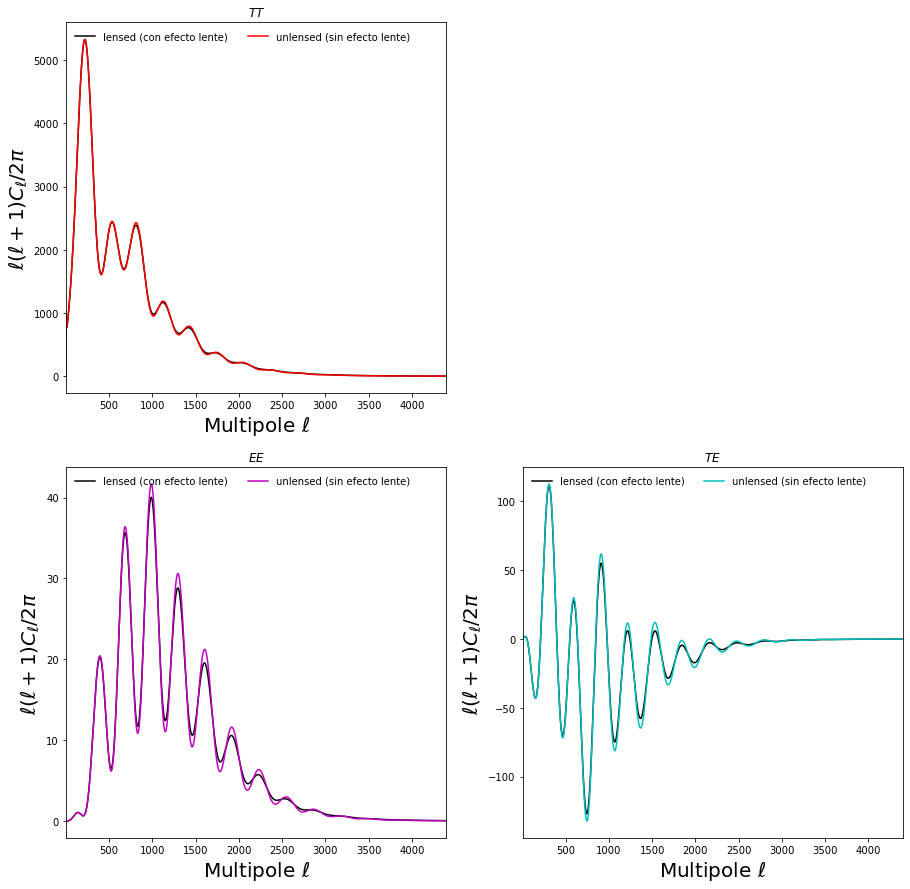

In [6]:
#Ahora graficaremos los espectros de potencia CMB total con y sin efecto lente.
totCL=powers['total']
CMBOutscale = 7.43e12
unlensedCL=powers['unlensed_scalar']
#Los arreglos CL de Python están todos basadas en cero (comenzando en L = 0), 
#tenga en cuenta que las entradas L = 0,1 serán cero de forma predeterminada.

#Los diferentes CL siempre están en el orden TT, EE, BB, TE (con BB=0 para resultados escalares sin lente).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (15,15 ))
ax[0,0].plot(ls,CMBOutscale*totCL[:,0], color='k', label='lensed (con efecto lente)')
ax[0,0].plot(ls,CMBOutscale*unlensedCL[:,0], color='r', label='unlensed (sin efecto lente)')
ax[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[0,0].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[0,0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
ax[0,0].set_title(r'$TT$')
ax[0,1].axis('off')
ax[1,0].plot(ls,CMBOutscale*totCL[:,1], color='k', label='lensed (con efecto lente)')
ax[1,0].plot(ls,CMBOutscale*unlensedCL[:,1], color='m', label='unlensed (sin efecto lente)')
ax[1,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2,frameon=False)
ax[1,0].set_title(r'$EE$')
ax[1,0].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[1,0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
ax[1,1].plot(ls,CMBOutscale*totCL[:,3], color='k', label='lensed (con efecto lente)')
ax[1,1].plot(ls,CMBOutscale*unlensedCL[:,3], color='c', label='unlensed (sin efecto lente)')
ax[1,1].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[1,1].set_title(r'$TE$');
ax[1,1].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[1,1].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)

for ax in ax.reshape(-1): ax.set_xlim([2,4400])

### Ahora que hemos ejecutado camb una vez y sabemos cómo hacerlo, también podemos calcular Cls sobre un rango de parámetros.

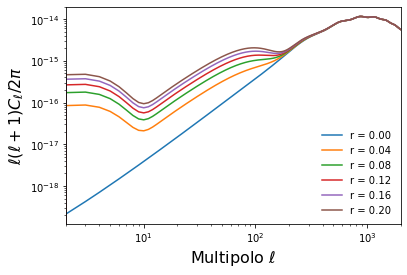

In [7]:
#Puedes calcular espectros para diferentes espectros de potencia primordial sin volver a calcular todo
#por ejemplo, representemos los espectros BB en función de r
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax)
    plt.loglog(np.arange(lmax+1),cl[:,2], label='r = %.2f'%r)
plt.xlim([2,lmax])
plt.xlabel(r'Multipolo $\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=16)
plt.legend( loc='lower right', frameon=False);

# Parte 2: Probabilidad ficticia simplificada para algunos datos de TT.
Comenzaremos con una probabilidad diagonal muy simple que es fácil de entender. Más adelante, la reemplazaremos con la verdadera probabilidad de ACT.

In [8]:
## Probabilidad falsa basada en simulaciones de ruido realistas a ell-alto para datos de CMB-S4

def s4_tt_likelihood(modell,loaddata=True,path=path_to_cmb_notebook_data):
    if loaddata: 
        # si es la primera vez, carga los datos
        data = np.loadtxt(path+'binned_errors.dat', unpack=True)
    modeltt = np.zeros(len(data[0]))
    inds = (data[0]-0.5)
    inds = inds.astype(int)
    for i,ind in enumerate(inds):
        modeltt[i] = modell[ind]  
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike
    

Lo primero que notamos es que no deberíamos simplemente tomar el espectro del modelo en ese bin, sino que deberíamos <font color='orange'> bineando </font>  la teoría

### Bineando los datos
Comenzaremos utilizando una función de binning con forma de "sombrero" (top hat) desde un límite inferior hasta un límite superior, con intervalos equidistantes.

(500.0, 2500.0, 0.0, 2000.0)

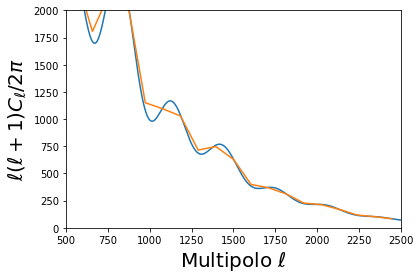

In [9]:
# Leer los valores de ell para los datos.
low_bin = 500
high_bin = 2500
nbin = 20

# Primero debemos asegurarnos de que los espectros de potencia teóricos estén en Cls y no en Dl = l^2Cl/2pi.
dl_tt = CMBOutscale*totCL[:,0]
ls[0] = 1. #evitar division por cero
cl_tt = np.divide(2*np.pi*CMBOutscale*totCL[:,0],ls**2)

# Ahora crearemos un vector de bin ell y un vector del mismo tamaño para guardar los cls.
ellbin = np.linspace(low_bin,high_bin,nbin)
ellmids = ellbin[0:-1]+ (ellbin[1:]-ellbin[0:-1])/2
clttbin = 0*ellmids

for c,ell in enumerate(ellbin[:-1]):
    inds = np.where((ls > ell)& (ls <= ellbin[c+1]))[0]
    clttbin[c] = np.mean(cl_tt[inds])

# Ahora vamos a transformar los valores de Cl de vuelta a Dl.
dlttbin = ellmids**2*clttbin/(2*np.pi)
plt.plot(ls,dl_tt, label='no-bineado')
plt.plot(ellmids,dlttbin, label='bineado')
plt.xlabel(r'Multipolo $\ell$', fontsize=20)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
plt.axis([500,2500,0,2000])

<font color='red'> EJERCICIO: </font> Experimenta con el binning anterior cambiando el rango y el número de intervalos. ¿Puedes pensar en cómo mejorarías la función de binning actual?


## Implementando binning dentro de la probabilidad
A menudo, el binning se realiza dentro de la propia probabilidad. Entonces, modifiquemos la probabilidad simple anterior para binear la teoría.


In [10]:
## Probabilidad falsa basada en simulaciones de ruido realistas a ell-alto para datos de CMB-S4

def s4_tt_likelihood_binned(modell,loaddata=True,path=path_to_cmb_notebook_data):
    print(path)
    if loaddata: 
        # si es que es la primera vez, carga los datos
        data = np.loadtxt(path + 'binned_errors.dat', unpack=True)
    
    modeltt = np.zeros(len(data[0]))
    model_ell = np.arange(len(modell))
    
    # Creando nuestro vector de binning
    midpt_ells = data[0]
    delta_ells = midpt_ells[2]-midpt_ells[1]
    
    ell_bins = midpt_ells - delta_ells/2.
    ell_bins[0] = 10 # En este caso, no queremos sumar los valores de ell por debajo de 10.
    
    ell_bins=np.append(ell_bins, ell_bins[-1]+ delta_ells/2. )

    # convirtiendo a Cl antes de calcular el promedio

    model_ell[0] = 1. #para evitar dividir por cero
    
    cltt = 2*np.pi*modell/(model_ell**2)

    for i,ell in enumerate(ell_bins[0:-1]):
        inds = np.where((model_ell > ell)& 
                        (model_ell <= ell_bins[i+1]))[0]
        
        modeltt[i] = np.mean(cltt[inds])
    # convirtiendo de vuelta a Dl para realizar el cálculo de chi^2
    modeltt = modeltt*data[0]**2/(2*np.pi)
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike
   
    

In [11]:
# Vamos a comparar
loglike = s4_tt_likelihood(dl_tt)
loglike_binned = s4_tt_likelihood_binned(dl_tt)
print(loglike, loglike_binned)

/Users/cvargas/CMBAnalysis_SummerSchool/
-5083.169106614558 -6124.974781257732


Notar la diferencia entre los dos resultados obtenidos con el mismo vector de datos.

## Part Tres: Probabilidad de datos reales

Ahora veamos la probabilidad real de ACT. Aquí estamos leyendo el espectro ajustado mejor a ACT como teoría, y también necesitamos definir `yp2` como 1.001, y para comparar, cargamos un nuevo espectro, aquel que maximiza la probabilidad en el nuevo valor de `yp2`:

In [12]:
like = pyactlike.ACTPowerSpectrumData()
# Lee los espectros solo de ACT.
filename = like.data_dir + "/bf_ACTPol_lcdm.minimum.theory_cl"

tt_lmax = 6000
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

# Establece el nuevo valor de yp2.
yp2_act_only = 1.001

# Ahora vamos a calcular el chi2 utilizando pyactlike.
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, yp2_act_only)
print("ACT solo chi2 = " + "{0:.12f}".format(chi2))
print("Esperado:       279.005057627002")

ACT solo chi2 = 279.005057627002
Esperado:       279.005057627002



Ahora vamos a tomar un momento para comparar nuestras predicciones teóricas con los datos. Para hacerlo, queremos identificar los bins de TT, TE y EE, así como los datos y errores. Vamos a utilizar los datos del parche "wide". La información específica del espectro (TT, EE, etc.) y del parche combinado se establece mediante los índices aplicados a las variables `like`:

In [13]:
wmin=130 #Primer elemento del vector de datos de TT para el parche "wide".
wmax=130+40 #Último elemento del vector de datos de TT para el parche "wide".

# Leer los valores de ell para los datos.
TT_bval=like.bval[wmin:wmax]

# Calcula los valores de Dl utilizando la fórmula Dl = cl * ell * (ell + 1) / (2 * pi).
TT_dat=like.X_data[wmin:wmax]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi)

# Lee el error, que también debe ser convertido a un error en Dl.
TT_err=like.X_sig[wmin:wmax]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi)

(0.0, 6000.0)

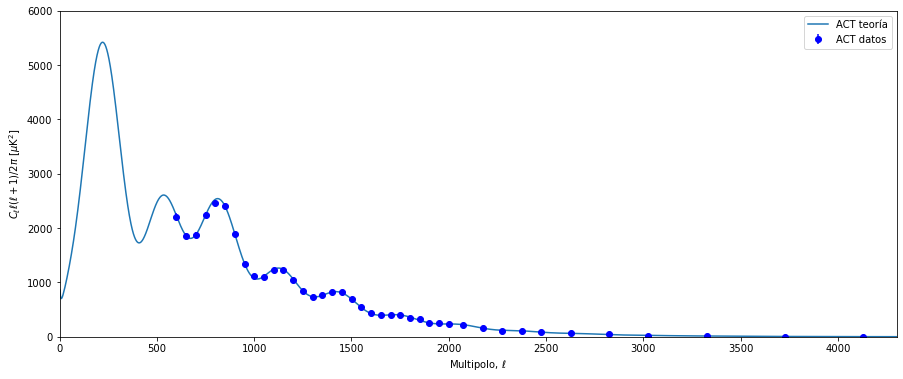

In [14]:
# Ahora podemos trazar estos datos junto con la teoría mencionada anteriormente.
plt.figure(figsize=(15,6))

plt.plot(ell, dell_tt, "-", label="ACT teoría")
plt.errorbar(TT_bval,TT_dat,yerr = TT_err, fmt='bo',label="ACT datos")
plt.xlabel(r"Multipolo, $\ell$")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()
plt.xlim(0,4300)
plt.ylim(0,6000)

Una simple inspección visual sugiere una buena concordancia entre los puntos de datos y la teoría. Sin embargo, para una evaluación más rigurosa, podemos examinar los residuos y calcular un $\chi^2$ simplificado en la diagonal. Es importante tener en cuenta que para obtener el $\chi^2$ completo, se necesitaría utilizar la función de probabilidad-logaritmica completa (like.loglike) en lugar de esta versión simplificada.

Ahora, vamos a identificar las funciones de ventana para binear la teoría, graficar los residuos y calcular el $\chi^2$ simplificado en la diagonal. Primero, necesitamos obtener un espectro de teoría bineado para compararlo con los datos bineados almacenados en `like`.

In [15]:
# Comenzamos creando un arreglo de valores de ell que abarca desde 2 hasta 5000.
l_list = np.array(range(2, like.tt_lmax + 1))

# Nuestros datos anteriores fueron bineados, por lo que, para poder compararlos con la teoría,
# necesitaremos binear de manera similar la curva teórica mencionada anteriormente.

# Comienza leyendo los valores de Dl y convirtiéndolos a cls.
cltt = np.zeros(like.lmax_win)
cltt[1 : like.tt_lmax] = (dell_tt[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)

# Ahora agrupamos estos valores de cl de la misma manera que lo hicimos con los datos anteriores.
bmax, lmax_win = like.bmax, like.lmax_win
cth_tt = like.win_func_w[2 * bmax : 3 * bmax, 1:lmax_win] @ cltt[1:lmax_win] 

# Convertimos los valores bineados cl nuevamente a valores bineados de Dl multiplicando por l(l+1)/2pi.
dth_tt = cth_tt[like.b0:like.b0+like.nbintt]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi) 

(-100.0, 70.0)

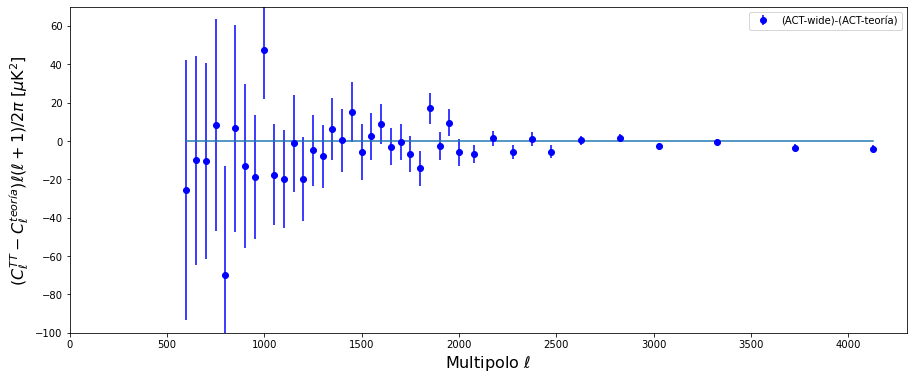

In [16]:
# Ahora tenemos datos agrupados y teoría agrupada, por lo que podemos trazar los residuos.

plt.figure(figsize=(15,6))
plt.errorbar(TT_bval,TT_dat-dth_tt,yerr = TT_err, fmt='bo',label="(ACT-wide)-(ACT-teoría)")
plt.plot(TT_bval, (TT_dat-dth_tt)*0.)
plt.xlabel(r"Multipolo $\ell$",fontsize=16)
plt.ylabel(r"$(C_{\ell}^{TT}-C_{\ell}^{teoría}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$",fontsize=16)
plt.legend()
plt.xlim(0,4300)
plt.ylim(-100,70)

Finalmente, a partir de los residuos y errores que cargamos anteriormente, podemos evaluar nuestro $\chi^2$ "diagonal":

In [17]:
# También podemos encontrar el chi^2 de estos datos bineados e imprimirlo.

chi_act_TT = (TT_dat-dth_tt)**2/TT_err**2
print("chi2 diagonal ACT TT-wide = " + "{0:.2f}".format(np.sum(chi_act_TT))+ " para 40 puntos de datos")

chi2 diagonal ACT TT-wide = 39.28 para 40 puntos de datos


### Repitiendo para TE, EE

In [18]:
wmin_TE, wmax_TE= 130+40, 130+40+45   #establecer los límites para TE
wmin_EE, wmax_EE= 130+85, 130+85+45   #establecer los límites para EE

# Como antes, leemos los valores de ell, Dl y error.
# Para TE
TE_bval=like.bval[wmin_TE:wmax_TE]
TE_dat=like.X_data[wmin_TE:wmax_TE]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi)
TE_err=like.X_sig[wmin_TE:wmax_TE]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi)

# Para EE
EE_bval=like.bval[wmin_EE:wmax_EE]
EE_dat=like.X_data[wmin_EE:wmax_EE]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]+1)/(2.*np.pi)
EE_err=like.X_sig[wmin_EE:wmax_EE]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]+1)/(2.*np.pi)

# Comienza bineando la teoría de EE.
clee = np.zeros(like.lmax_win)
clee[1 : like.tt_lmax] = (dell_ee[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)
bmax, lmax_win = like.bmax, like.lmax_win
cth_ee = like.win_func_w[9 * bmax : 10 * bmax, 1:lmax_win] @ clee[1:lmax_win] 
dth_ee = cth_ee[:like.nbinee]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]*+1)/(2.*np.pi) 

# A continuación, bineamos la teoría de TE.
clte = np.zeros(like.lmax_win)
clte[1 : like.tt_lmax] = (dell_te[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)
bmax, lmax_win = like.bmax, like.lmax_win
cth_te = like.win_func_w[6 * bmax : 7 * bmax, 1:lmax_win] @ clte[1:lmax_win] 
dth_te = cth_te[:like.nbinte]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi) 

ACT TE-wide diagonal chi2 = 40.77 for 45 data points
ACT EE-wide diagonal chi2 = 60.04 for 45 data points


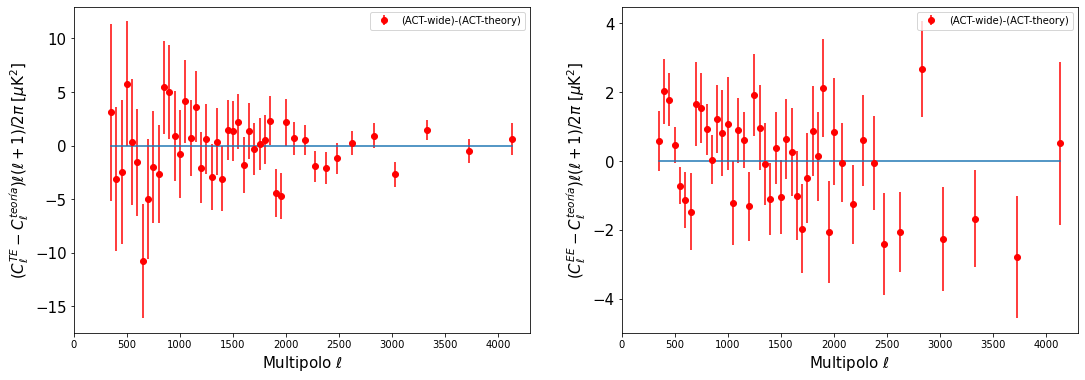

In [19]:
# Graficar los residuos
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.errorbar(TE_bval,TE_dat-dth_te,yerr = TE_err, fmt='ro',label="(ACT-wide)-(ACT-theory)")
plt.plot(TE_bval, (TE_dat-dth_te)*0.)
plt.yticks(fontsize=15)
plt.xlim(0,4300)
plt.xlabel(r"Multipolo $\ell$",fontsize=15)
plt.ylabel(r"$(C_{\ell}^{TE}-C_{\ell}^{teoría}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$",fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(EE_bval,EE_dat-dth_ee,yerr = EE_err, fmt='ro',label="(ACT-wide)-(ACT-theory)")
plt.plot(EE_bval, (EE_dat-dth_ee)*0.)
plt.yticks(fontsize=15)
plt.xlim(0,4300)
plt.xlabel(r"Multipolo $\ell$",fontsize=15)
plt.ylabel(r"$(C_{\ell}^{EE}-C_{\ell}^{teoría}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$",fontsize=15)
plt.legend()

# Imprime los valores de chi^2.
chi_act_TE = (TE_dat-dth_te)**2/TE_err**2
print("ACT TE-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_TE))+ " for 45 data points")

chi_act_EE = (EE_dat-dth_ee)**2/EE_err**2
print("ACT EE-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_EE))+ " for 45 data points")

<font color='red'>EJERCICIO: </font> Repite el proceso para el parche `deep` (donde veas que se accede a los datos a través de los objetos de probabilidad en el código anterior, cambia el número "130" por "0"). Comenta cualquier similitud/diferencia que observes.

Opcionalmente, en el siguiente paso, utiliza las herramientas más adelante en el cuaderno para determinar qué parámetros cosmológicos están mejor restringidos por cada parche.

In [20]:
## Tu código va aquí

### Avanzando en el espacio de parámetros.

Ahora vamos a explorar la generación de diferentes 'universos' modelo para ajustar los datos.


In [21]:
# Primero generemos un conjunto arbitrario de espectros utilizando CAMB.
cosmo_params = camb.model.CAMBparams()

# Establece H0 como el mejor ajuste de ACT+WMAP y fijamos la curvatura del universo ligeramente positiva.
cosmo_params.set_cosmology(H0 = 67.9, omk = 0.1)
# Establece el valor de lmax para esta simulación para que coincida con el resto del cuaderno.
cosmo_params.set_for_lmax(6000)

# Recupera los espectros.
res = camb.get_results(cosmo_params)
spectra = res.get_cmb_power_spectra(params = cosmo_params, spectra = ('total',), CMB_unit = 'muK')['total']

Podemos graficar cómo se ve nuestro nuevo modelo (visualmente es difícil notar la diferencia con nuestra teoría de máxima probabilidad solo de ACT), pero en comparación con los datos, el problema es evidente.

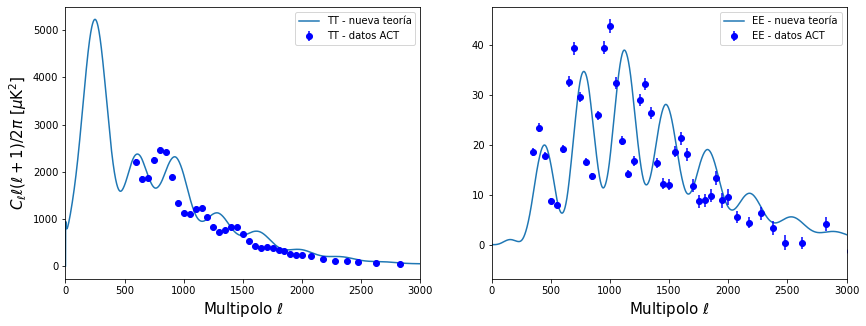

In [22]:
# Podemos graficar los nuevos espectros teóricos como antes.
ell_new = np.arange(spectra.shape[0])
dell_tt_new, dell_ee_new, dell_bb_new, dell_te_new = spectra.T

plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.plot(ell_new, dell_tt_new, "-", label="TT - nueva teoría")
plt.errorbar(TT_bval,TT_dat,yerr = TT_err, fmt='bo',label="TT - datos ACT")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$", fontsize = 15)
plt.xlabel(r"Multipolo $\ell$", fontsize = 15)
plt.legend()
plt.xlim(0,3000)

plt.subplot(1,2,2)
plt.plot(ell_new, dell_ee_new, "-", label="EE - nueva teoría")
plt.errorbar(EE_bval,EE_dat,yerr = EE_err, fmt='bo', label="EE - datos ACT")
plt.xlabel(r"Multipolo $\ell$", fontsize = 15)
plt.legend()
plt.xlim(0,3000)

plt.show()

In [23]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
pars = camb.CAMBparams()
pars.set_cosmology(H0=paramsvec[0], ombh2=paramsvec[1], omch2=paramsvec[2], mnu=0.06, omk=paramsvec[3], tau=paramsvec[4])
pars.InitPower.set_params(ns=paramsvec[5], r=0)
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#Calcula los resultados para estos parámetros.
results = camb.get_results(pars)

#Obtiene un diccionario de los espectros de potencia de CAMB.
powers =results.get_cmb_power_spectra(pars)
totCL=powers['total']
model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(cltt)
print(loglike)

-5083.169106614558


Calcular el $\chi^2$ para la probabilidad de ACT confirma esto.

In [24]:
# Observa el chi^2 utilizando pyactlike.
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt_new, dell_te_new, dell_ee_new, yp2_act_only)
print("chi2 solo ACT  = " + "{0:.12f}".format(chi2))
print("Esperado:        279.004901885481")

chi2 solo ACT  = 34358.760519029653
Esperado:        279.004901885481


### Avanzando en el espacio de parámetros.

Ahora vamos a llamar a CAMB con un vector de parámetros de la misma manera que antes y calcularemos la probabilidad-logaritmica para esto. Queremos dar un paso en este espacio de parámetros de 6 dimensiones especificado por el vector de paso.


In [25]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
# Usando el código anterior, podemos dar un paso gaussiano especificado por el vector de paso a continuación.
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
nsteps = 2
loglike = np.zeros(nsteps)
for i in range(nsteps):
    if i==0:
        # Primer paso
        step = paramsvec
    else:
        # Damos un paso gaussiano desde la posición anterior.
        step = step+np.random.randn(len(paramsvec))*stepvec
    # Inicializa los parámetros de CAMB.    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
    pars.InitPower.set_params(ns=step[5], r=0)
    pars.set_for_lmax(4400, lens_potential_accuracy=0)
    # Calcula los espectros.
    powers =results.get_cmb_power_spectra(pars)
    totCL=powers['total']
    model = totCL
    cltt = totCL[:,0]*CMBOutscale
    loglike[i] = s4_tt_likelihood(cltt)
print('loglike vector =', loglike)

loglike vector = [-5083.16910661 -4645.91401878]


## Part Cuatro: Preliminares del MCMC

Ahora estamos listos para realizar el MCMC. Definiremos la versión más simple/fea del algoritmo Metropolis Hastings.

In [26]:
def mcmc_mh(ratln):
    accept=False
    r1 = np.random.rand()
    # Si el paso es definitivamente mejor, queremos aceptarlo.
    # Si no es necesariamente mejor, queremos generar un número aleatorio y dar un paso si lo superamos.
    if np.exp(ratln) > r1:
        accept=True
    return accept

In [27]:
# Usando el código anterior, podemos dar un paso gaussiano especificado por el vector de paso a continuación.
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
# stepvec = np.array([0.1,0, 0, 0, 0, 0])

steps = 10
loglike = np.zeros(steps)
stepskeep = np.zeros((steps,len(paramsvec)+1))
for i in range(steps):
    
    if i==0:
        step = paramsvec
        accept=True
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        loglike[i] = s4_tt_likelihood(cltt)
        #print loglike[i]
        stepskeep[i,0:len(paramsvec)] = step
        stepskeep[i,len(paramsvec)]= loglike[i]
    else:
        
        step = stepskeep[i-1,0:len(paramsvec)]+np.random.randn(len(paramsvec))*stepvec 
        #print step
        pars = camb.CAMBparams()
        # Coloca el vector de parámetros en la estructura de CAMB.
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        # Calcula el espectro de potencia.
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        # Calcula la probabilidad.
        loglike[i] = s4_tt_likelihood(cltt)
        rat = loglike[i]-loglike[i-1]
        accept = mcmc_mh(rat)
        
        if accept:   
            stepskeep[i,0:len(paramsvec)] = step
            stepskeep[i,len(paramsvec)] = loglike[i]
        else:
            stepskeep[i,0:len(paramsvec)] = stepskeep[i-1,0:len(paramsvec)]
            loglike[i] = loglike[i-1]
            stepskeep[i,len(paramsvec)] = loglike[i]
        
np.savetxt('cadena.txt', stepskeep, delimiter=' ', fmt='%.3e')
print('estamos listos')

/var/folders/x6/1c1sz3rn4kj8kvd0rzmjjbcm0000gn/T/ipykernel_94840/2678648010.py:6: RuntimeWarning: overflow encountered in exp
  if np.exp(ratln) > r1:


estamos listos


### En realidad, no queremos leer los datos cada vez.

<font color='red'>EJERCICIO: </font> Cambia la función de probabilidad para que solo lea los datos la primera vez que se llama.

In [28]:
## Tu código va aquí

Tus notas aquí.

### ¡Este código es realmente feo (y lento)!
<font color='red'>EJERCICIO:</font> Escribe funciones/módulos para acelerar el código MCMC anterior.

In [29]:
## Tu código va aquí

Tu discusión va aquí.

## Parte Cinco: Análisis de cadenas MCMC

Utilizaremos cadenas MCMC generadas utilizando la probabilidad de ACT para analizar los parámetros. La probabilidad que hemos introducido anteriormente se puede utilizar para obtener los mejores parámetros cosmológicos que se ajustan a los datos de ACT. Este proceso y nuestros resultados se discuten más en [Choi et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_C20.pdf) y [Aiola et al (2020)](https://phyact1.princeton.edu/public/saiola/act_dr4_A20.pdf), pero aquí te mostraremos cómo usar una de las cadenas MCMC para analizar los parámetros.
Comenzamos leyendo una cadena y un archivo con los nombres de columna correspondientes.

In [30]:
# Comienza leyendo una cadena y los nombres de las columnas
import pandas as pd


# Lee los nombres de las columnas.
names = pd.read_csv(path_to_act_notebook_data + "ACTPol_lcdm.paramnames.csv", names = ["parameter", "latex parameter name"])
chain = np.genfromtxt(path_to_act_notebook_data + "ACTPol_lcdm_1.txt")
names["parameter"]

0         omegabh2
1         omegach2
2            theta
3              tau
4             logA
5               ns
6               yp
7              H0*
8          omegal*
9          omegam*
10       omegamh2*
11      omeganuh2*
12       omegamh3*
13         sigma8*
14     s8omegamp5*
15    s8omegamp25*
16           s8h5*
17     rmsdeflect*
18           zrei*
19              A*
20          clamp*
21           DL40*
22          DL220*
23          DL810*
24         DL1420*
25         DL2000*
26           ns02*
27        yheused*
28          YpBBN*
29          DHBBN*
30            age*
31          zstar*
32          rstar*
33      thetastar*
34         DAstar*
35          zdrag*
36          rdrag*
37             kd*
38         thetad*
39            zeq*
40            keq*
41        thetaeq*
42      thetarseq*
43        rsDv057*
44      Hubble057*
45          DA057*
46         FAP057*
47    fsigma8z057*
48     sigma8z057*
49    chi2_ACTPol*
50     chi2_prior*
Name: parameter, dtype: object

### Realizando gráficas de parámetros 1D y gráficas de contorno 2D.

Ahora que hemos leído la cadena, podemos examinar los datos más de cerca. A menudo es útil examinar las gráficas de parámetros 1D y las gráficas de contorno 2D, por ejemplo, examinar solo $H_0$ o examinar $H_0$ con $\Omega_m$. En esta sección demostraremos dos formas en las que los usuarios pueden ver estas gráficas. La primera es un ejemplo sencillo que utiliza matplotlib para crear gráficas 1D y 2D para esta cadena. La otra opción es utilizar [GetDist](https://getdist.readthedocs.io/en/latest/), un software público desarrollado por Antony Lewis ([Lewis 2019](https://arxiv.org/abs/1910.13970)) específicamente para representar cadenas MCMC del CMB. Comenzaremos con el ejemplo sencillo de matplotlib. Aquí utilizaremos $H_0$ y $\Omega_m$, pero podrías utilizar cualquiera de los parámetros de la lista anterior.


Text(0, 0.5, 'Densidad de Probabilidad')

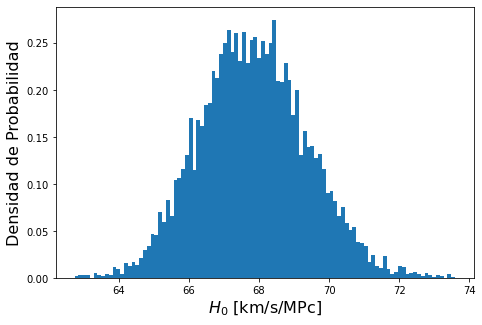

In [31]:
#Comenzamos con la gráfica 1D de H0. Vale la pena señalar que, dado que las dos primeras columnas de las 
#cadenas son la iteración y la probabilidad, agregamos +2 al número de columna mostrado anteriormente al 
#llamar a las columnas en nuestra gráfica (es decir, queremos H0 que es el séptimo parámetro anterior, 
#por lo que graficamos chain[:, 9]) para obtener H0. Usamos un histograma para examinar los datos aquí

plt.figure(figsize = (7.5,5))
plt.hist(chain[:,9], bins = 100, density = True)
plt.xlabel("$H_0$ [km/s/MPc]", fontsize = 16)
plt.ylabel("Densidad de Probabilidad", fontsize = 16)

Es fácil generalizar a proyecciones multidimensionales de la probabilidad, por ejemplo, examinando la distribución conjunta de $H_0$ y $\Omega_m$ ahora:

Text(0.5, 0, '$H_0$ [km/s/MPc]')

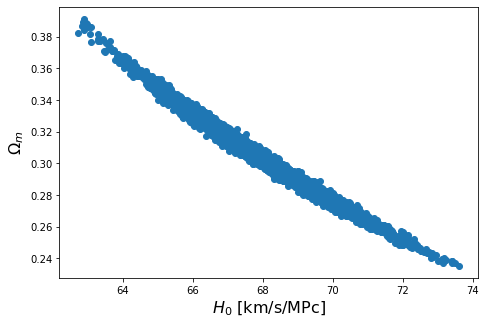

In [32]:
# Ahora intentemos un ejemplo en 2D agregando Omega de materia:
plt.figure(figsize = (7.5, 5))
plt.scatter(chain[:,9], chain[:,11])
plt.ylabel("$\Omega_m$", fontsize = 16)
plt.xlabel("$H_0$ [km/s/MPc]", fontsize = 16)

Ahora hagamos los mismos gráficos usando GetDist. Primero debemos volver a leer los archivos utilizando el método de GetDist. A partir de ahí, veremos cómo hacer los 2 gráficos mencionados anteriormente.

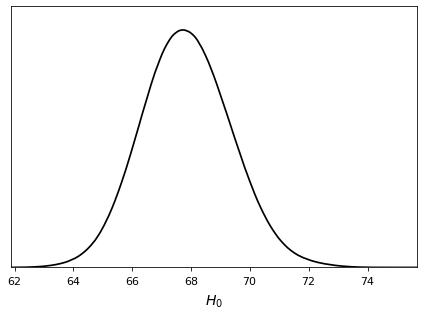

In [33]:
from getdist import loadMCSamples, plots

# Leamos las muestras usando GetDist.
samples = loadMCSamples(path_to_act_notebook_data + 'ACTPol_lcdm', path_to_act_notebook_data + "ACTPol_lcdm_1.txt")

# Comencemos nuevamente con la versión de 1D.
g = plots.get_single_plotter()
g.plot_1d(samples, 'H0', marker_color='k')
plt.show()

Como puedes ver, el gráfico anterior es similar a nuestro histograma, ¡pero mucho más atractivo! También podemos usar GetDist para gráficos en 2D utilizando la función `plot_2d` de GetDist.

((61.88535221163013, 75.67826446864929),
 (0.22258948430097583, 0.42084048532280444))

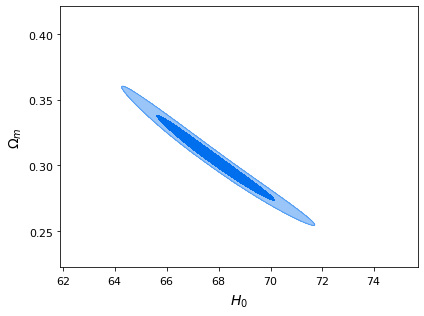

In [34]:
# Ahora podemos crear un gráfico de contorno en 2D utilizando las muestras que cargamos anteriormente.
g = plots.get_single_plotter()
g.plot_2d(samples, ['H0', 'omegam'], filled=True, )

<font color='red'>EJERCICIO: </font>  Examinar la correlación entre otros parámetros.

<font color='red'>EJERCICIO: </font>  Comparar estos gráficos 1D y 2D con los equivalentes para la cadena que se ejecutó anteriormente.

In [35]:
# Tu código va aquí

Tu discusión aquí

## Part Seis: (Ejercicio) Mejorando el algoritmo MCMC

Ahora queremos verificar la razon de aceptación/rechazo de las cadenas. En general, queremos que esté entre 0.2 y 0.4. Para cambiar esto, debes ajustar el tamaño de los pasos en cada dirección de parámetro.


<font color='red'>EXCERCISE: </font>  Modifica el código anterior para calcular la razón de aceptación/rechazo mientras se realizan los pasos.

In [36]:
## Tu código va aquí

Tu discusión aquí

En general, es útil estar en una parte adecuada del espacio de parámetros al comenzar y no dar pasos utilizando una matriz de paso diagonal, sino dar pasos utilizando la correlación entre los parámetros.

<font color='red'>EJERCICIO: </font>  Modifica la función escalonada para tomar una matriz de covarianza (determinada a partir de un recorrido más corto de la cadena) y dar pasos esta matriz de covarianza.


In [37]:
## Tu código va aquí

Tu discusión aquí